# Analyze Model

How well does our trained model perform on unseen data? 

In [4]:
import tensorflow as tf
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np 
from scipy import stats

import os

Load the data

In [5]:
# Some useful functions

# Routine to normalize between 0 and 1 (Following the atmospheric turbulence paper)

def norm_data(x):
    for ii in range(len(x)):
        x[ii] = (x[ii] - np.min(x))/(np.max(x) - np.min(x))
    return x

def loadData(direc_name, time_steps):
    
    total_input = []
    total_output = []
    
    # Files expected
    
    directory_list = [name for name in os.listdir(f'{direc_name}/.')]
    
    
    for ii, name in enumerate(directory_list):
        df = pd.read_csv(f'{direc_name}/{name}')
        
        dataset_weather = np.empty((time_steps, 4))
        dataset_output = np.empty((1, 2))
        
        ###### INPUT DATA #######
        
        # In the 0th input, temperature
        dataset_weather[:,0] = df["temperature"].to_numpy()
        # In the 1st input, relative humidity (%)
        dataset_weather[:,1] = df["relative_humidity"].to_numpy()
        # In the 2nd input, standard pressure 
        dataset_weather[:,2] = df["pressure_station"].to_numpy()
        #In the 3rd input, Solar Radiation 
        dataset_weather[:,3] = df["solar_radiation"].to_numpy()
        total_input.append(dataset_weather)
        
        ###### OUTPUT DATA #######
        
        # In the 0th output, CN2 FUTURE
        dataset_output[:,0] = np.log10(eval(df["CN2-R0 Future"][1]))
        # In the 1st output, R0
        # dataset_output[:,1] = df["CN2-R0 Future"][2]  
    
        total_output.append(dataset_output)
        
    total_input = np.array(total_input)
    total_output = np.array(total_output)
    
    # Apply normalization to each input entry
    
    total_input[:,:,0] = norm_data(total_input[:,:,0])
    total_input[:,:,1] = norm_data(total_input[:,:,1])
    total_input[:,:,2] = norm_data(total_input[:,:,2])
    total_input[:,:,3] = norm_data(total_input[:,:,3])
    
    total_output[:,:,0] = norm_data(total_output[:,:,0])
    #total_output[:,:,1] = norm_data(total_output[:,:,1])

    return total_input, total_output

direc_name = "Batched Data/OneHourAhead" # yaml worthy
sizeOfFiles = len([name for name in os.listdir(f'{direc_name}/.')]) # Global parameter
print(f"Number of files:{sizeOfFiles}")
train_factor = 0.90
num_of_examples = int(sizeOfFiles*train_factor)
X, y = loadData(direc_name, 12)
X_train, y_train = X[0:num_of_examples], y[0:num_of_examples]
X_test, y_test = X[num_of_examples::], y[num_of_examples::]

Number of files:4416


Load trained model

In [6]:
model_direc = 'gruRNN_Feb13_2411'


loaded_model = tf.keras.models.load_model(f'models/{model_direc}')

# Plot Model Predictions vs. Ground Truths

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

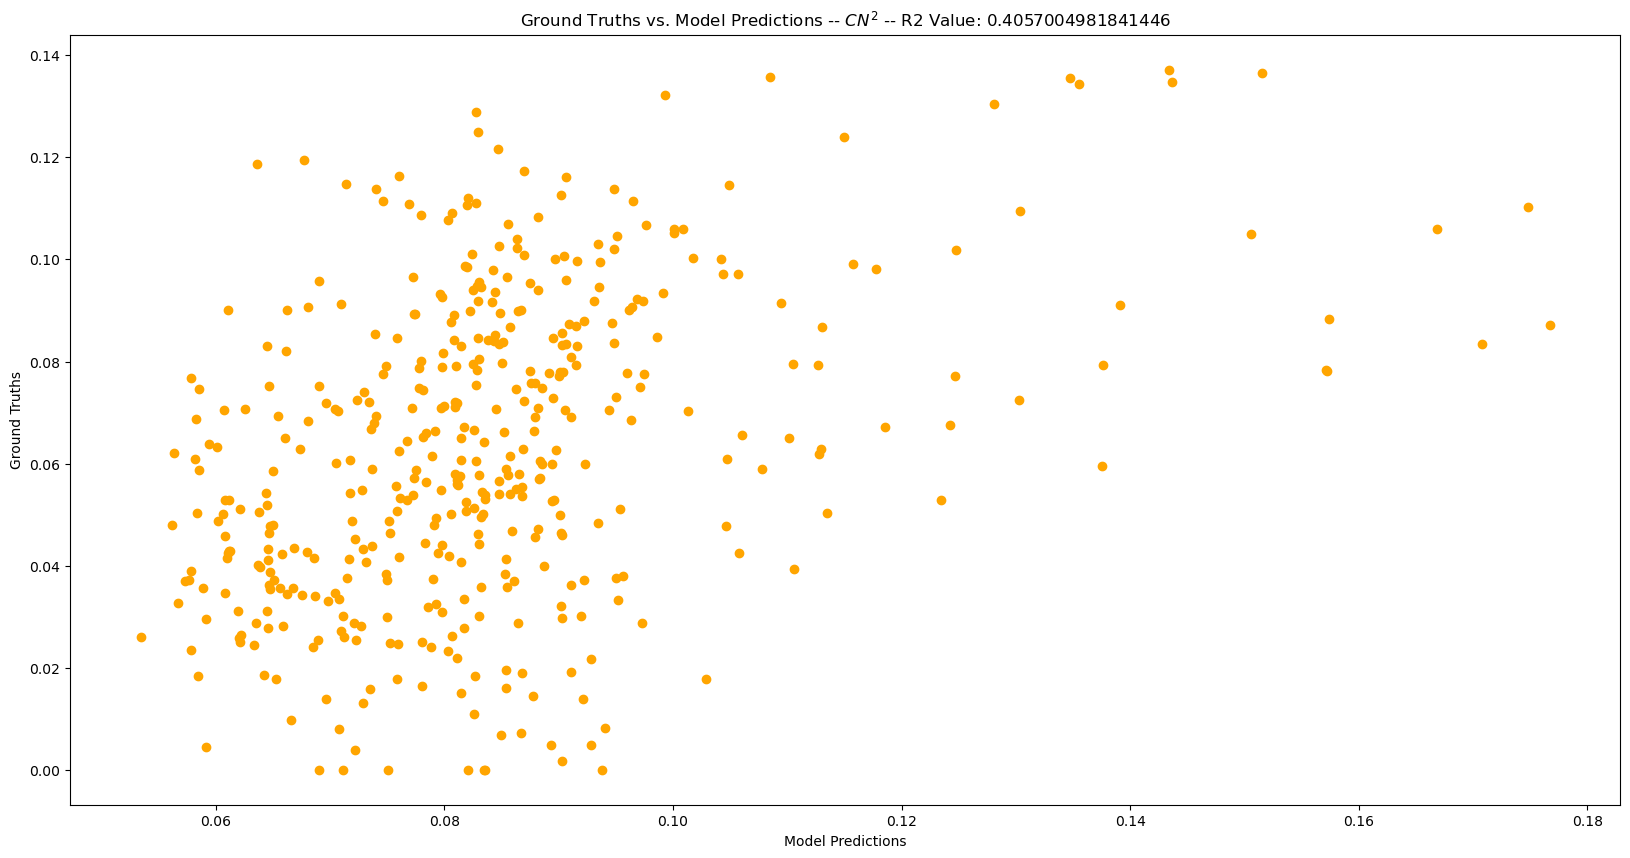

In [9]:
model_predictions = []

for ii,x in enumerate(X_test):
    print(ii)
    funky = tf.expand_dims(x, axis=0)
    preds = loaded_model.predict(funky, verbose=False)
    model_predictions.append(preds)
    
model_predictions = np.array(model_predictions)
Cn2_pred = model_predictions[:,0,0]
#r0_pred = model_predictions[:,0,1]

Cn2_true = y_test[:,0,0]
#r0_true = y_test[:,0,1]


Results on training data
Slope:0.6401913258644499, intercept:0.009195352038866442, r_value:0.4057004981841446


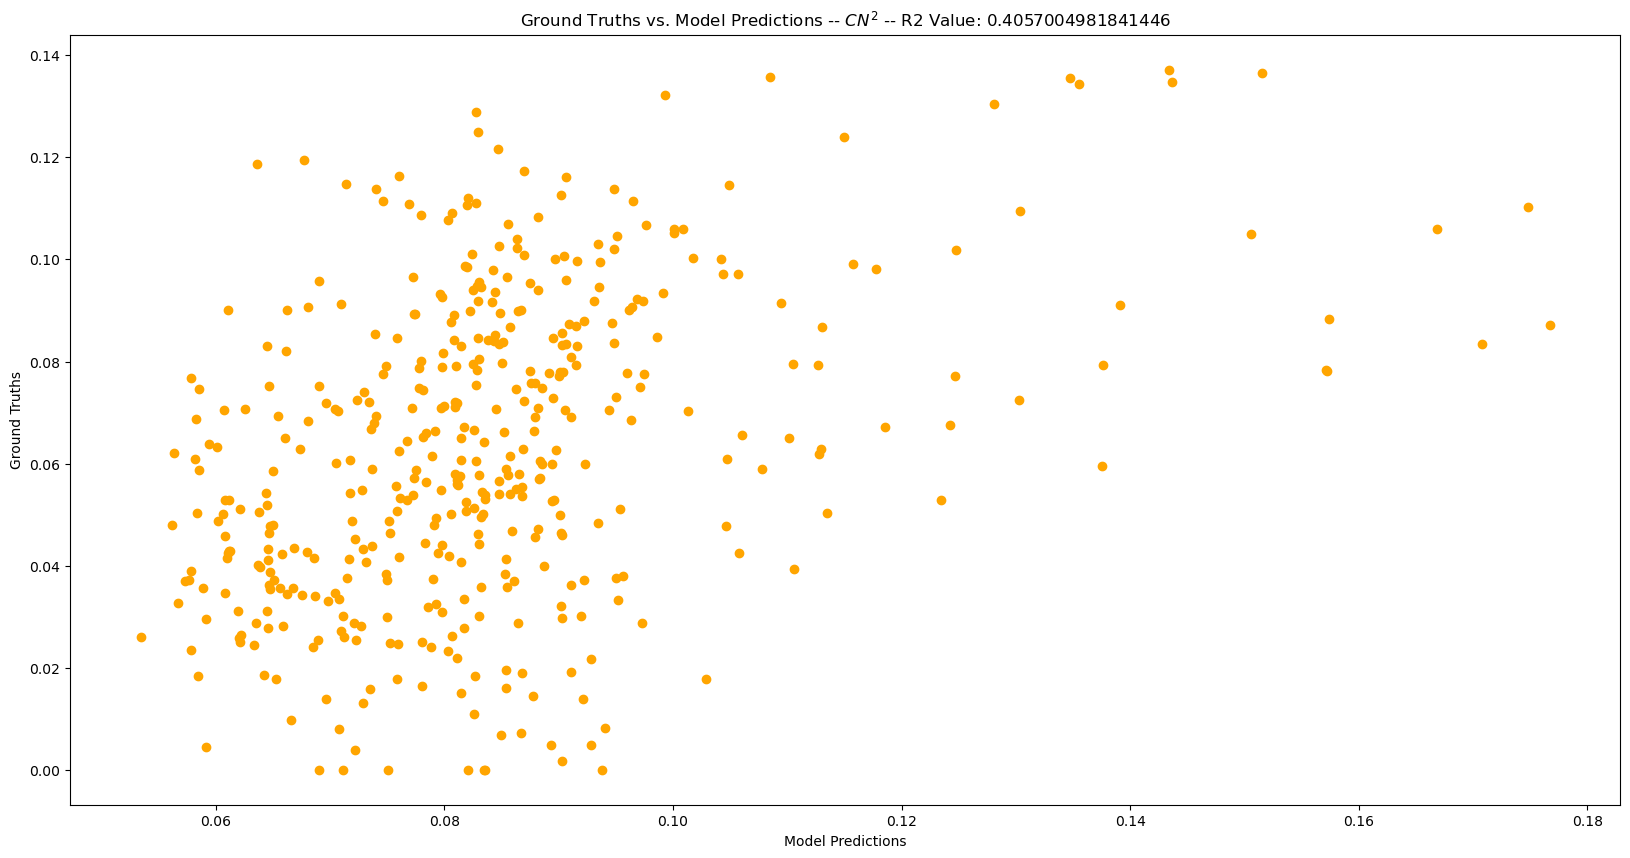

In [13]:
# Compute R2 value

slope_cn, intercept_cn, r_value_cn, p_value_cn, std_err_cn = stats.linregress(Cn2_pred, Cn2_true)

print("Results on training data")
print(f"Slope:{slope_cn}, intercept:{intercept_cn}, r_value:{r_value_cn}")

#slope_r0, intercept_r0, r_value_r0, p_value_r0, std_err_r0 = stats.linregress(r0_pred, r0_true)

#print("Results on training data")
#print(f"Slope:{slope_r0}, intercept:{intercept_r0}, r_value:{r_value_r0}")

fig, ax = plt.subplots(1,1, figsize=(20,10))

'''
ax[0].scatter(r0_pred, r0_true, color='blue')
ax[0].set_xlabel('Model Predictions')
ax[0].set_ylabel('Ground Truths')
ax[0].set_title(f'Ground Truths vs. Model Predictions -- R0 -- R2 Value: {r_value_r0}')
'''

ax.scatter(Cn2_pred, Cn2_true, color='orange')
ax.set_xlabel('Model Predictions')
ax.set_ylabel('Ground Truths')
ax.set_title(f'Ground Truths vs. Model Predictions -- $CN^{2}$ -- R2 Value: {r_value_cn}')
plt.savefig(f'R2Plots/{model_direc}.png', bbox_inches='tight')

Save plot as a png 

<Figure size 640x480 with 0 Axes>